# Estimating narrow-sense heritability

Narrow sense heritability, $h^2$ is the ratio of variance due to average/additive effects of alleles. Where $Var(A)$ is the variance due to this addative effect and $Var(P)$ is the total phenotypic variance:

$$h^2 = \frac{Var(A)}{Var(P)}$$

## Computing $h^2$

The total variance of the phenotype includes the variance from the additive genetic component $Var(A)$, as well as a components from environemntal and non-additive genetic effects which are collectively $Var(\neg A)$. 

$$Var(P) = Var(A) + Var(\neg A)$$

We will model the additive component of the phenotype $A$ by training a linear model that will predict a phenotype value given the input genotype. The model will learn one weight per variant (i.e. SNPs from both haplotypes will be combined into a single feature with a value of 0, 1, or 2). The coefficient of determination for this model is the narrow sense heritability $h^2$, but I'll derive that from the fraction of variance unexplained for clarity.

The fraction of variance unexplained (FVU) is the fraction of variance for a target variable in a regression not explained by the model. In this case, the target variable is the phenotype and the model is the linear model of the additive genetic component. For a linear regression, this is equivalent to $ 1 - R^2 $, where $R^2$ is the coefficient of determination for the linear regression model.

$$ FVU = \frac{Var(\neg A)}{Var(P)} = 1 - R^2 $$

From here we can find that $h^2 = R^2$.

$$ Var(A) = Var(P) (1 - FVU) = Var(P) [1 - (1 - R^2)] = Var(P) R^2 $$

$$ h^2 = \frac{Var(A)}{Var(P)} = \frac{Var(P) R^2}{Var(P)} = R^2 $$

## Implementation

The 'narrow_sense_heritability' function, which estimates $h^2$ and provides a confidence interval, is implemented in [pheno_sim/heritability_estimation/herit_est.py](../../pheno_sim/heritability_estimation/herit_est.py). It's docstring is reproduced below:

```python
Estimates simulation's narrow-sense heritability for a given simulation.
	
Estimates narrow-sense heritability (h^2) for a given simulation by
fitting a linear regression model (that models the additive genetic 
effect on the phenotype). The model is fit using the genotypes with
haplotypes summed as the input features and simulated phenotypes
as the label.

For each of 'n_iterations' iterations the following procedure is
followed:

	1. Randomly sample 'n_samples' fraction/number of individuals
		from the input data.
	2. For each individual, simulate 'n_pheno_per_geno' phenotypes.
	3. Split the (genotype, simulated phenotype) pairs into 'n_folds'
		folds, such that each genotype is in exactly one fold. This
		prevents a genotype from being in the training and testing
		data.
	4. For each fold, fit the model on the training data and compute
		the model's R^2 score on the test data.
	5. Add the R^2 score to a list

The list of R^2 scores is effectively a list of h^2 estimates for
the given simulation (see narrow sense heritability estimation example
notebook). An overall statistic (typically mean or median) defined
by 'statistic_fn' is computed from the list of R^2 scores, as well
as a bootstrap confidence interval. The confidence interval is
computed using the 'confidence_level' parameter.

Args:
	sim (PhenoSimulation): The simulation to estimate narrow-sense
		heritability for.
	input_vals (default None): A ValuesDict containing the input
			values. If None, will run the input step of the simulation.
	n_samples (default 1.0): The fraction or number of samples to
		use when estimating heritability. If value is less than or
		equal to 1, will use that fraction of samples. If value is
		greater than 1, will use that number of samples. Samples
		will be randomly selected from the input samples.
	n_pheno_per_geno (default 100): The number of phenotypes to
		simulate per genotype each iteration.
	n_folds (default 5): The number of folds to divide the simulated
		phenotypes into each iteration. Each genotype will be in
		exactly one fold.
	n_iterations (default 5): The number of times to repeat the
		procedure of sampling individuals, simulating phenotypes,
		and computing the R^2 scores.
	statistic_fn (default np.mean): The statistic to compute from
		the list of R^2 scores. Typically np.mean or np.median.
	confidence_level (default 0.95): The confidence level to use
		when computing the bootstrap confidence interval.
	phenotype_alias (default 'phenotype'): Output phenotype alias
		in simulation.

Returns:
	Dict with keys:
		- 'h2': The estimated narrow-sense heritability.
		- 'h2_ci_lower': The lower bound of the bootstrap confidence
			interval.
		- 'h2_ci_upper': The upper bound of the bootstrap confidence
			interval.
```

# Estimating broad-sense heritability

Broad-sense heritability is the proportion of phenotypic variance that is due to genetic effects.

In the following equations $Var(P)$ is the phenotypic variance, $Var(G)$ is the genetic variance, and $Var(E)$ is the environmental variance of the trait.

Broad sense heritability is definied as:

$$ H^2 = \frac{Var(G)}{Var(P)} $$

The phenotypic variance is defined as ([See here for more detail](https://si.biostat.washington.edu/sites/default/files/modules/SISG_Heritability.pdf)):

$$ Var(P) = Var(G) + Var(E) + 2Cov(G,E) $$

In CITRUS simulations, the genetic and environmental effects are independant (no gene x environment interactions), so $Cov(G,E) = 0$ and the phenotypic variance is simply:

$$ Var(P) = Var(G) + Var(E) $$

## Computing $H^2$

The following steps are used to estimate $H^2$ for a given phenotype. This procedure is done repeatedly to get a central measure of broad-sense heritability and a confidence interval via bootstrapping.

### Steps:

1. Simulate phenotype for $n$ individuals $r$ times.

2. Estimate $Var(P)$ using the variance of all simulated phenotypes.

3. Find expected $Var(E)$ using the mean of intra-genotype phenotype variances.

	Let $Var(P_i)$ be the variance of the phenotype for genotype $i$. Let $Var(G_i)$ be the variance of the genotype for genotype $i$. We assume $Var(G_i) = 0$, or that in the absence of noise the genotype is deterministic (which is true for CITRUS).

	$$ Var(P_i) = Var(G_i) + E[Var(E_i)] $$
	$$ E[Var(E)] = Mean(Var(P_i))|_{i \in n} $$

4. Estimate $Var(G)$ using the difference between $Var(P)$ and $Var(E)$.

	$$ Var(G) = Var(P) - E[Var(E)] $$

5. Compute heritability estimate as:

	$$ H^2 = \frac{Var(G)}{Var(P)} $$

## Implementation

The 'broad_sense_heritability' function, which estimates $H^2$ and provides a confidence interval, is implemented in [pheno_sim/heritability_estimation/herit_est.py](../../pheno_sim/heritability_estimation/herit_est.py). It's docstring is reproduced below:

```python
Estimates simulation's broad-sense heritability for a given simulation.
	
See broad sense heritability estimation example notebook for more details
on the procedure.

Args:
	sim (PhenoSimulation): The simulation to estimate narrow-sense
		heritability for.
	input_vals (default None): A ValuesDict containing the input
			values. If None, will run the input step of the simulation.
	n_samples (default 1.0): The fraction or number of samples to
		use when estimating heritability. If value is less than or
		equal to 1, will use that fraction of samples. If value is
		greater than 1, will use that number of samples. Samples
		will be randomly selected from the input samples.
	n_pheno_per_geno (default 250): The number of phenotypes to
		simulate per genotype each iteration.
	n_folds (default 5): The number of folds to divide the simulated
		phenotypes into each iteration. Each genotype will be in
		exactly one fold.
	n_iterations (default 5): The number of times to repeat the
		procedure of sampling individuals, simulating phenotypes,
		and computing the R^2 scores.
	statistic_fn (default np.mean): The statistic to compute from
		the list of R^2 scores. Typically np.mean or np.median.
	confidence_level (default 0.95): The confidence level to use
		when computing the bootstrap confidence interval.
	phenotype_alias (default 'phenotype'): Output phenotype alias
		in simulation.

Returns:
	Dict with keys:
		- 'H2': The estimated broad-sense heritability.
		- 'H2_ci_lower': The lower bound of the bootstrap confidence
			interval.
		- 'H2_ci_upper': The upper bound of the bootstrap confidence
			interval.
```

## Example: Additive vs Dominance

Here we'll look at the difference in narrow-sense heritability between phenotypes that share the same architecture but differ in having all additive or all dominant effects.

In [1]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pheno_sim import PhenoSimulation
from pheno_sim.heritability_estimation import (
    narrow_sense_heritability,
    broad_sense_heritability
)
    

/Users/ross/Desktop/gwas/CITRUS/pheno_sim/heritability_estimation/herit_est.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
def gen_config(heritability=1.0, combine_type="AdditiveCombine"):
	"""Return linear additive model config with specified heritability
	and haplotype combine node type.
	"""

	return {
		"input": [
			{
				"file": "1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz",
				"file_format": "vcf",
				"reference_genome": "GRCh37",
				"force_bgz": True,
				"input_nodes": [
					{
						"alias": "rare_variants",
						"type": "SNP",
						"chr": "19",
						"pos": [13397324, 52901080, 16023111]
					},
					{
						"alias": "common_variants",
						"type": "SNP",
						"chr": "19",
						"pos": [55555845, 55261043, 45857820, 55442280, 39369369]
					}
				]
			}
		],
		"simulation_steps": [
			{
				"type": "RandomConstant",
				"alias": "rare_variants_betas",
				"input_match_size": "rare_variants",
				"dist_name": "normal",
				"dist_kwargs": {
					"loc": 0.0,
					"scale": 0.5
				},
				"by_feat": True
			},
			{
				"type": "RandomConstant",
				"alias": "common_variants_betas",
				"input_match_size": "common_variants",
				"dist_name": "normal",
				"dist_kwargs": {
					"loc": 0.0,
					"scale": 0.2
				},
				"by_feat": True
			},
			{
				"type": "Product",
				"alias": "rare_variant_effects",
				"input_aliases": [
					"rare_variants_betas", "rare_variants"
				]
			},
			{
				"type": "Product",
				"alias": "common_variant_effects",
				"input_aliases": [
					"common_variants_betas", "common_variants"
				]
			},
			{
				"type": "Concatenate",
				"alias": "variant_effects",
				"input_aliases": [
					"rare_variant_effects", "common_variant_effects"
				],
			},
			{
				"type": combine_type,
				"alias": "combined_variant_effects",
				"input_alias": "variant_effects"
			},
			{
				"type": "SumReduce",
				"alias": "no_noise_phenotype",
				"input_alias": "combined_variant_effects"
			},
			{
				"type": "Heritability",
				"alias": "phenotype",
				"input_alias": "no_noise_phenotype",
				"heritability": heritability
			}
		]
	}

In [3]:
# Load input data
sim = PhenoSimulation(gen_config())
input_vals = sim.run_input_step()

Initializing Hail with default parameters...


Loading input data...


SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://desktop-oj0d0vr.localdomain:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.118-a4ca239602bb
LOGGING: writing to /Users/ross/Desktop/gwas/CITRUS/doc/example_nbs/hail-20230814-1328-0.2.118-a4ca239602bb.l

In [6]:
# Options
conf_level = 0.99
n_herit = 6
combine_types = ['Additive', 'Max']

narrow_kwargs = {
    'n_pheno_per_geno': 250
}
broad_kwargs = {
    'n_pheno_per_geno': 500,
}

In [7]:
from itertools import product

# Compute heritabilites
results = []

for herit, comb_type in product(np.linspace(0, 1, n_herit), combine_types):
	iter_res = {
		"true_heritability": herit,
		"inheritance": comb_type
	}

	sim = PhenoSimulation(gen_config(
		heritability=herit,
		combine_type=f"{comb_type}Combine"
	))

	iter_res.update(
		narrow_sense_heritability(
			sim,
			input_vals=input_vals,
			confidence_level=conf_level,
			**narrow_kwargs
		)
	)
	iter_res.update(
		broad_sense_heritability(
			sim,
			input_vals=input_vals,
			confidence_level=conf_level,
			**broad_kwargs
		)
	)

	results.append(iter_res)

# To DataFrame
res_df = pd.DataFrame(results)	

100%|██████████| 5/5 [00:08<00:00,  1.66s/it]
/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/scipy/stats/_resampling.py:144: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
100%|██████████| 10/10 [00:18<00:00,  1.80s/it]
/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/scipy/stats/_resampling.py:144: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is kno

In [8]:
res_df

,true_heritability,inheritance,h2,h2_ci_lower,h2_ci_upper,H2,H2_ci_lower,H2_ci_upper
0,0.0,Additive,-0.000019,-0.000032,-0.000005,0.001995,0.001934,0.002022
1,0.0,Max,-0.000028,-0.000041,-0.000014,0.001979,0.001938,0.002011
2,0.2,Additive,0.199916,0.195011,0.206233,0.201643,0.201227,0.201914
3,0.2,Max,0.181378,0.175996,0.189439,0.201820,0.201334,0.202228
4,0.4,Additive,0.393757,0.361104,0.423082,0.401245,0.400805,0.401780
5,0.4,Max,0.299680,0.286575,0.307963,0.401359,0.400757,0.401942
6,0.6,Additive,0.597591,0.579040,0.610692,0.600886,0.600503,0.601384
7,0.6,Max,0.428732,0.423373,0.434575,0.600735,0.600182,0.601109
8,0.8,Additive,0.799228,0.793738,0.804036,0.800508,0.800311,0.800739
9,0.8,Max,0.653486,0.641555,0.666781,0.800437,0.800293,0.800586


In [9]:
residual_df = res_df.melt(
    id_vars=['true_heritability', 'inheritance'],
    value_vars=['h2', 'H2'],
    var_name='estimated heritability type',
)
residual_df['residual'] = residual_df['value'] - residual_df['true_heritability']

Text(0.5, 0, 'True heritability')

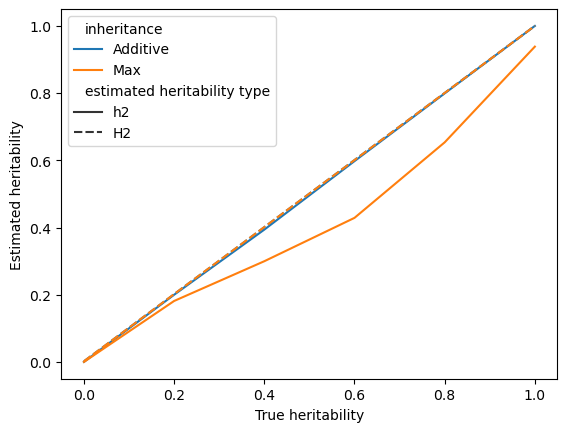

In [10]:
# Plot estimated h^2 vs. true h^2 by inheritance model
sns.lineplot(
    data=residual_df,
    x="true_heritability",
    y="value",
    hue="inheritance",
    style="estimated heritability type"
)
plt.ylabel("Estimated heritability")
plt.xlabel("True heritability")

In [11]:
mdf = res_df.melt(
    id_vars=['true_heritability', 'inheritance'],
    value_name='estimated_heritability',
    var_name='method'
)

mdf['heritability_type'] = mdf['method'].apply(
    lambda x: 'narrow-sense' if 'h2' in x else 'broad-sense'
)
mdf['value'] = mdf['method'].apply(
    lambda x: 'upper CI' if 'upper' in x else 'lower CI' if 'lower' in x else 'center'
)

mdf['true_heritability'] = mdf['true_heritability'].round(3)

mdf['estimated - true heritability'] = mdf['estimated_heritability'] - mdf['true_heritability']

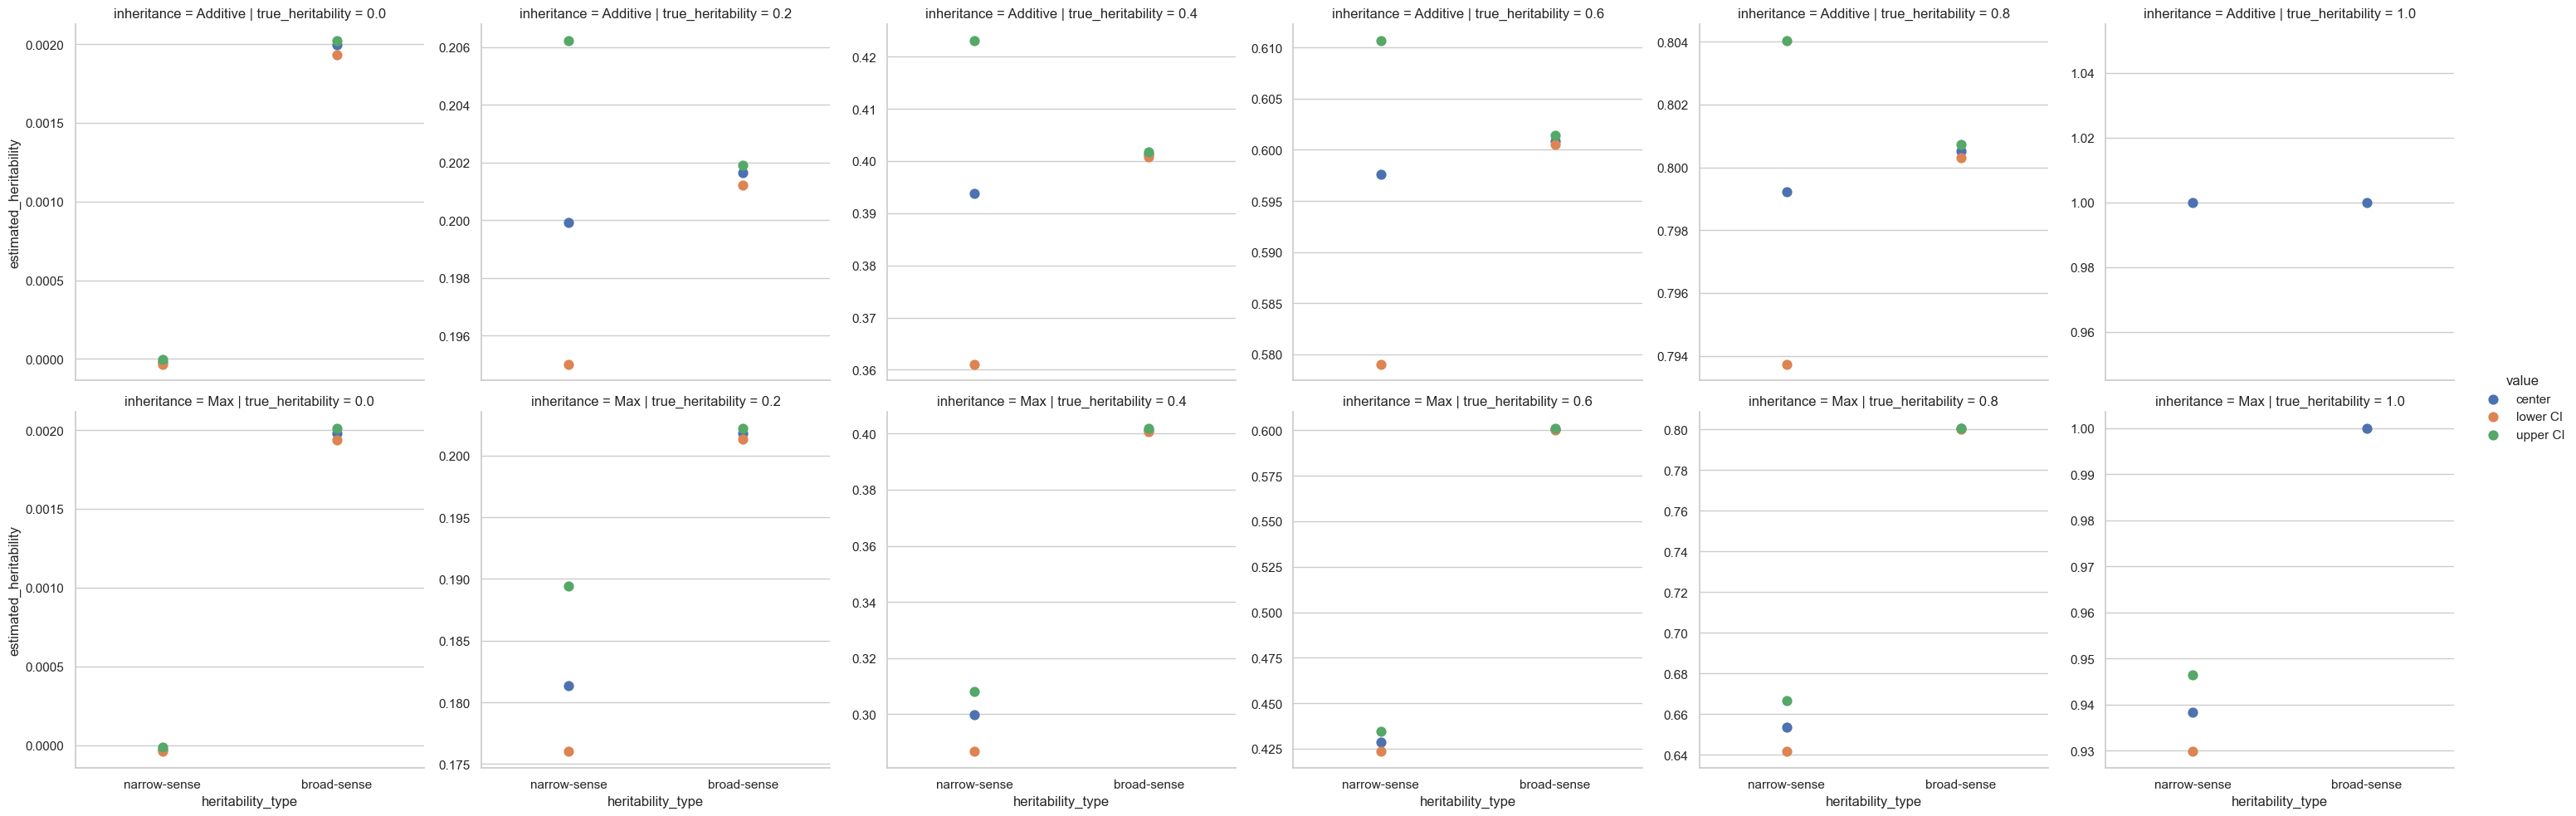

In [12]:
sns.set(style='whitegrid')
sns.catplot(
    data=mdf,
    kind='point',
    col='true_heritability',
    row='inheritance',
    y='estimated_heritability',
    hue='value',
    x='heritability_type',
    sharey=False,
    dodge=False,
    join=False,
)


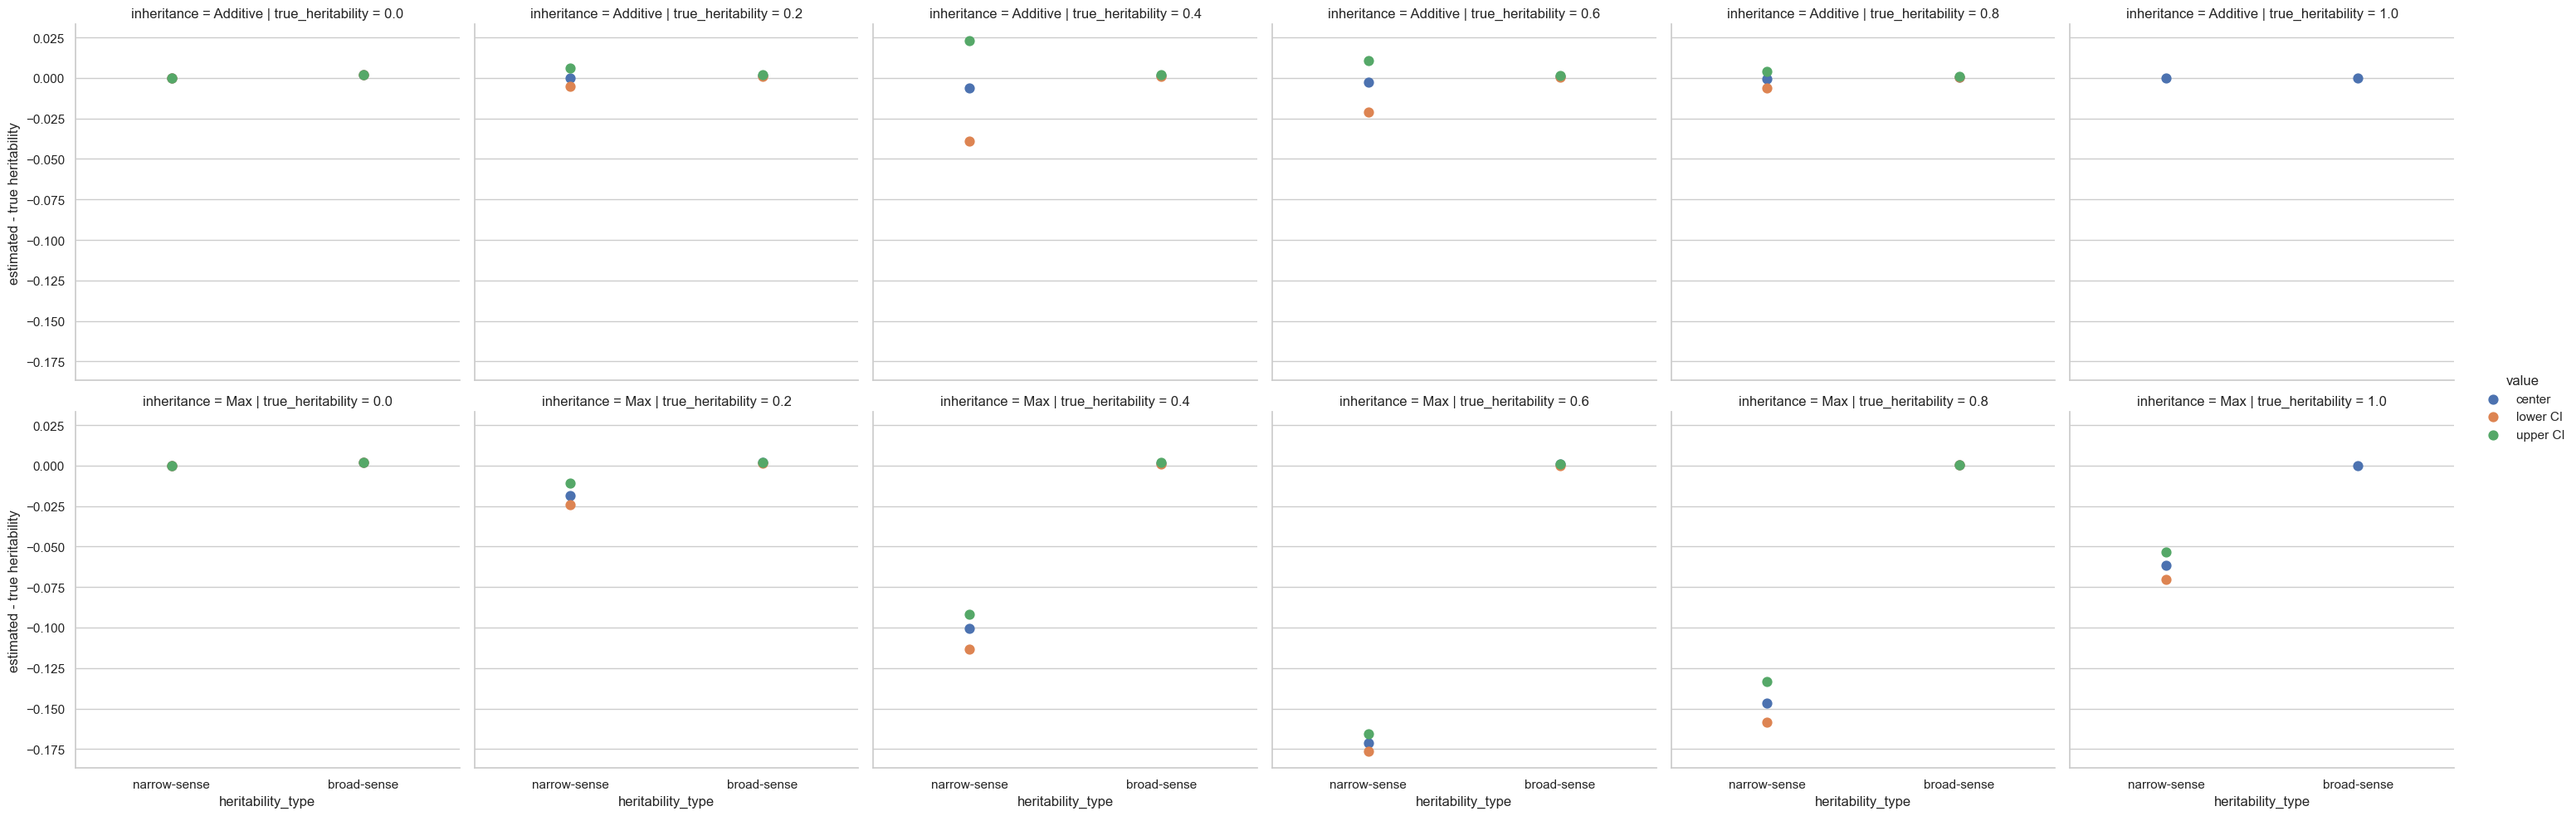

In [13]:
sns.set(style='whitegrid')
sns.catplot(
    data=mdf,
    kind='point',
    col='true_heritability',
    row='inheritance',
    y='estimated - true heritability',
    hue='value',
    x='heritability_type',
    sharey=True,
    dodge=False,
    join=False,
)